##### Copyright 2025 Google LLC.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Building an AI-Powered Research Agent with LangGraph and Gemini

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/mainexamples/langgraph/Deep_Research.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

## Overview

This notebook demonstrates how to build an advanced AI research agent that can autonomously conduct web searches, analyze results, and synthesize comprehensive answers to complex questions. The agent uses Google's Gemini API for natural language processing and LangGraph for orchestrating a multi-step research workflow.
The research agent features:

* Intelligent query generation - Automatically generates multiple search queries based on your question
* Web research capabilities - Conducts Google searches and gathers information
* Self-reflection - Evaluates if gathered information is sufficient and identifies knowledge gaps
* Iterative improvement - Generates follow-up queries to fill information gaps
Comprehensive synthesis - Produces well-structured answers based on all gathered research

<!-- Community Contributor Badge -->
<table>
  <tr>
    <!-- Author Avatar Cell -->
    <td bgcolor="#d7e6ff">
      <a href="https://github.com/andycandy" target="_blank" title="View Anand Roy's profile on GitHub">
        <img src="https://github.com/andycandy.png?size=100"
             alt="andycandy's GitHub avatar"
             width="100"
             height="100">
      </a>
    </td>
    <!-- Text Content Cell -->
    <td bgcolor="#d7e6ff">
      <h2><font color='black'>This notebook was contributed by <a href="https://github.com/andycandy" target="_blank"><font color='#217bfe'><strong>Anand Roy</strong></font></a>.</font></h2>
      <h5><font color='black'><a href="https://www.linkedin.com/in/anand-roy-61a2b529b"><font color="#078efb">LinkedIn</font></a> - See <a href="https://github.com/andycandy" target="_blank"><font color="#078efb"><strong>Anand</strong></font></a> other notebooks <a href="https://github.com/search?q=repo%3Agoogle-gemini%2Fcookbook%20%22Anand%20Roy%22&type=code" target="_blank"><font color="#078efb">here</font></a>.</h5></font><br>
      <!-- Footer -->
      <font color='black'><small><em>Have a cool Gemini example? Feel free to <a href="https://github.com/google-gemini/cookbook/blob/main/CONTRIBUTING.md" target="_blank"><font color="#078efb">share it too</font></a>!</em></small></font>
    </td>
  </tr>
</table>

## Setup
First, install the required packages and configure your environment.

### Installation
Install LangGraph for workflow orchestration, LangChain for LLM integration, and supporting libraries.

In [2]:
%pip install -q langgraph
%pip install -q langchain-google-genai
%pip install -q langchain python-dotenv

### Import Required Libraries

In [3]:
import os
from datetime import datetime
from typing import Any, Dict, List, TypedDict, Optional
import operator
import types

from dotenv import load_dotenv
from google import genai
from langchain_core.messages import AnyMessage, AIMessage, HumanMessage
from langchain_core.runnables import RunnableConfig
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, add_messages, START, END
from langgraph.types import Send
from pydantic import BaseModel, Field
from typing_extensions import Annotated

### Configure your API key and load the environment

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Authentication.ipynb) for an example.

In [4]:
from google.colab import userdata
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

os.environ['GOOGLE_API_KEY'] = GOOGLE_API_KEY
load_dotenv()

genai_client = genai.Client()

## Define Data Models and State
The research agent uses structured data models to ensure consistent communication between different components of the workflow.

### Pydantic Models for Structured Outputs
These models define the expected structure of outputs from our LLMs, ensuring type safety and validation.

In [5]:
class SearchQueryList(BaseModel):
    """Model for generating search queries"""
    query: List[str] = Field(
        description="A list of search queries to be used for web research."
    )
    rationale: str = Field(
        description="A brief explanation of why these queries are relevant to the research topic."
    )


class Reflection(BaseModel):
    """Model for evaluating research completeness"""
    is_sufficient: bool = Field(
        description="Whether the provided summaries are sufficient to answer the user's question."
    )
    knowledge_gap: str = Field(
        description="A description of what information is missing or needs clarification."
    )
    follow_up_queries: List[str] = Field(
        description="A list of follow-up queries to address the knowledge gap."
    )

### State Definitions
LangGraph uses TypedDict classes to define the state that flows through the graph. Each node can read from and write to this shared state.

In [6]:
class OverallState(TypedDict):
    """Main state that flows through the entire graph"""
    messages: Annotated[list, add_messages]
    search_query: Annotated[list, operator.add]
    web_research_result: Annotated[list, operator.add]
    sources_gathered: Annotated[list, operator.add]
    initial_search_query_count: int
    max_research_loops: int
    research_loop_count: int
    reasoning_model: str


class ReflectionState(TypedDict):
    """State for the reflection process"""
    is_sufficient: bool
    knowledge_gap: str
    follow_up_queries: Annotated[list, operator.add]
    research_loop_count: int
    number_of_ran_queries: int


class Query(TypedDict):
    """Individual query structure"""
    query: str
    rationale: str


class QueryGenerationState(TypedDict):
    """State for query generation"""
    query_list: list[Query]


class WebSearchState(TypedDict):
    """State for web search operations"""
    search_query: str
    id: str

### Configuration
Define configurable parameters that control the agent's behavior. You can adjust these to optimize for different use cases.

In [7]:
configurable = types.SimpleNamespace(
    query_generator_model="gemini-2.0-flash",
    reflection_model="gemini-2.5-flash",
    answer_model="gemini-2.5-flash",
    number_of_initial_queries=3,
    max_research_loops=2,
)

## Define Helper Functions

These utility functions support the main workflow by extracting information from messages and formatting dates.


In [8]:
def get_research_topic(messages: List[AnyMessage]) -> str:
    """
    Extract the research topic from the conversation messages.
    """
    if len(messages) == 1:
        research_topic = messages[-1].content
    else:
        research_topic = ""
        for message in messages:
            if isinstance(message, HumanMessage):
                research_topic += f"User: {message.content}\n"
            elif isinstance(message, AIMessage):
                research_topic += f"Assistant: {message.content}\n"
    return research_topic


def get_current_date():
    """Get the current date in a readable format."""
    return datetime.now().strftime("%B %d, %Y")


## Define Prompt Templates

These templates guide the LLMs at each stage of the research process. They're designed to produce high-quality, structured outputs.


### Query Generation Prompt

In [9]:
query_writer_instructions = """Your goal is to generate sophisticated and diverse web search queries. These queries are intended for an advanced automated web research tool capable of analyzing complex results, following links, and synthesizing information.

Instructions:
- Always prefer a single search query, only add another query if the original question requests multiple aspects or elements and one query is not enough.
- Each query should focus on one specific aspect of the original question.
- Don't produce more than {number_queries} queries.
- Queries should be diverse, if the topic is broad, generate more than 1 query.
- Don't generate multiple similar queries, 1 is enough.
- Query should ensure that the most current information is gathered. The current date is {current_date}.

Format:
- Format your response as a JSON object with ALL three of these exact keys:
   - "rationale": Brief explanation of why these queries are relevant
   - "query": A list of search queries

Example:

Topic: What revenue grew more last year apple stock or the number of people buying an iphone
```json
{{
    "rationale": "To answer this comparative growth question accurately, we need specific data points on Apple's stock performance and iPhone sales metrics. These queries target the precise financial information needed: company revenue trends, product-specific unit sales figures, and stock price movement over the same fiscal period for direct comparison.",
    "query": ["Apple total revenue growth fiscal year 2024", "iPhone unit sales growth fiscal year 2024", "Apple stock price growth fiscal year 2024"],
}}
```

Context: {research_topic}"""


### Web Search Prompt


In [10]:
web_searcher_instructions = """Conduct targeted Google Searches to gather the most recent, credible information on "{research_topic}" and synthesize it into a verifiable text artifact.

Instructions:
- Query should ensure that the most current information is gathered. The current date is {current_date}.
- Conduct multiple, diverse searches to gather comprehensive information.
- Consolidate key findings while meticulously tracking the source(s) for each specific piece of information.
- The output should be a well-written summary or report based on your search findings.
- Only include the information found in the search results, don't make up any information.

Research Topic:
{research_topic}
"""

### Reflection Prompt

In [11]:
reflection_instructions = """You are an expert research assistant analyzing summaries about "{research_topic}".

Instructions:
- Identify knowledge gaps or areas that need deeper exploration and generate a follow-up query. (1 or multiple).
- If provided summaries are sufficient to answer the user's question, don't generate a follow-up query.
- If there is a knowledge gap, generate a follow-up query that would help expand your understanding.
- Focus on technical details, implementation specifics, or emerging trends that weren't fully covered.

Requirements:
- Ensure the follow-up query is self-contained and includes necessary context for web search.

Output Format:
- Format your response as a JSON object with these exact keys:
   - "is_sufficient": true or false
   - "knowledge_gap": Describe what information is missing or needs clarification
   - "follow_up_queries": Write a specific question to address this gap

Example:
```json
{{
    "is_sufficient": true, // or false
    "knowledge_gap": "The summary lacks information about performance metrics and benchmarks", // "" if is_sufficient is true
    "follow_up_queries": ["What are typical performance benchmarks and metrics used to evaluate [specific technology]?"] // [] if is_sufficient is true
}}
```

Reflect carefully on the Summaries to identify knowledge gaps and produce a follow-up query. Then, produce your output following this JSON format:

Summaries:
{summaries}
"""

### Answer Generation Prompt

In [12]:
answer_instructions = """Generate a high-quality answer to the user's question based on the provided summaries.

Instructions:
- The current date is {current_date}.
- You are the final step of a multi-step research process, don't mention that you are the final step.
- You have access to all the information gathered from the previous steps.
- You have access to the user's question.
- Generate a high-quality answer to the user's question based on the provided summaries and the user's question.

User Context:
- {research_topic}

Summaries:
{summaries}"""

## Define Workflow Nodes
Each node in our LangGraph workflow represents a specific step in the research process. These functions process the state and return updates.

### 1. Query Generation Node
This node generates initial search queries based on the user's question.

In [13]:
def generate_query(state: OverallState) -> QueryGenerationState:
    """
    Generate search queries based on the user's research topic.
    """
    if state.get("initial_search_query_count") is None:
        state["initial_search_query_count"] = configurable.number_of_initial_queries

    llm = ChatGoogleGenerativeAI(
        model=configurable.query_generator_model,
        temperature=1.0,
        max_retries=2,
    )
    structured_llm = llm.with_structured_output(SearchQueryList)

    current_date = get_current_date()
    formatted_prompt = query_writer_instructions.format(
        current_date=current_date,
        research_topic=get_research_topic(state["messages"]),
        number_queries=state["initial_search_query_count"],
    )

    result = structured_llm.invoke(formatted_prompt)
    return {"query_list": result.query}

### 2. Query Distribution Function
This function distributes queries to parallel web research nodes.

In [14]:
def continue_to_web_research(state: QueryGenerationState):
    """
    Send each generated query to a separate web research node for parallel processing.
    """
    return [
        Send("web_research", {"search_query": search_query, "id": int(idx)})
        for idx, search_query in enumerate(state["query_list"])
    ]

### 3. Web Research Node
This node performs actual web searches using Gemini's built-in Google Search tool.

In [15]:
def web_research(state: WebSearchState) -> OverallState:
    """
    Conduct web research for a specific search query using Gemini's search capabilities.
    """
    formatted_prompt = web_searcher_instructions.format(
        current_date=get_current_date(),
        research_topic=state["search_query"]
    )

    response = genai_client.models.generate_content(
        model=configurable.query_generator_model,
        contents=formatted_prompt,
        config={"tools": [{"google_search": {}}], "temperature": 0},
    )

    return {
        "search_query": [state["search_query"]],
        "web_research_result": [response.text],
    }

### 4. Reflection Node
This node evaluates whether the gathered information is sufficient to answer the user's question.

In [16]:
def reflection(state: OverallState) -> ReflectionState:
    """
    Reflect on the gathered research to determine if it's sufficient or if more research is needed.
    """
    state["research_loop_count"] = state.get("research_loop_count", 0) + 1
    reflection_model = configurable.reflection_model
    current_date = get_current_date()

    formatted_prompt = reflection_instructions.format(
        current_date=current_date,
        research_topic=get_research_topic(state["messages"]),
        summaries="\n\n---\n\n".join(state["web_research_result"]),
    )

    llm = ChatGoogleGenerativeAI(
        model=reflection_model,
        temperature=1.0,
        max_retries=2,
    )
    result = llm.with_structured_output(Reflection).invoke(formatted_prompt)

    print(f"Reflection result: {result}")

    return {
        "is_sufficient": result.is_sufficient,
        "knowledge_gap": result.knowledge_gap,
        "follow_up_queries": result.follow_up_queries,
        "research_loop_count": state["research_loop_count"],
        "number_of_ran_queries": len(state["search_query"]),
    }

### 5. Research Evaluation Function
This function decides whether to continue researching or finalize the answer.

In [17]:
def evaluate_research(state: ReflectionState) -> OverallState:
    """
    Evaluate if more research is needed based on reflection results and loop count.
    """
    max_research_loops = (
        state.get("max_research_loops")
        if state.get("max_research_loops") is not None
        else configurable.max_research_loops
    )

    if state["is_sufficient"] or state["research_loop_count"] >= max_research_loops:
        return "finalize_answer"
    else:
        # Generate follow-up research tasks
        return [
            Send(
                "web_research",
                {
                    "search_query": follow_up_query,
                    "id": state["number_of_ran_queries"] + int(idx),
                },
            )
            for idx, follow_up_query in enumerate(state["follow_up_queries"])
        ]

### 6. Answer Finalization Node
This node synthesizes all gathered research into a comprehensive answer.

In [18]:
def finalize_answer(state: OverallState):
    """
    Generate the final answer based on all gathered research.
    """
    print("Finalizing answer...")
    answer_model = configurable.answer_model
    current_date = get_current_date()

    formatted_prompt = answer_instructions.format(
        current_date=current_date,
        research_topic=get_research_topic(state["messages"]),
        summaries="\n---\n\n".join(state["web_research_result"]),
    )

    llm = ChatGoogleGenerativeAI(
        model=answer_model,
        temperature=0,
        max_retries=2,
    )
    result = llm.invoke(formatted_prompt)

    return {
        "messages": [AIMessage(content=result.content)],
    }

## Build the Research Agent Graph
Now we'll assemble all the nodes into a LangGraph workflow that orchestrates the entire research process.

In [19]:
# Create the graph
graph = StateGraph(OverallState)

# Add nodes to the graph
graph.add_node("generate_query", generate_query)
graph.add_node("web_research", web_research)
graph.add_node("reflection", reflection)
graph.add_node("finalize_answer", finalize_answer)

# Define the workflow edges
graph.add_edge(START, "generate_query")
graph.add_conditional_edges(
    "generate_query", continue_to_web_research, ["web_research"]
)
graph.add_edge("web_research", "reflection")
graph.add_conditional_edges(
    "reflection", evaluate_research, ["web_research", "finalize_answer"]
)
graph.add_edge("finalize_answer", END)

# Compile the graph
app = graph.compile(name="pro-search-agent")

## Visualize the Workflow
Let's visualize the research agent's workflow to better understand how information flows through the system.

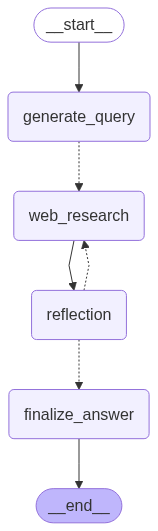

In [20]:
# Display the graph structure
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))


## Try Your Research Agent
Now you can interact with your AI research agent! Ask complex questions that require gathering information from multiple sources.

In [25]:
while True:
    user_input = input(" Your question (or 'quit' to exit): ")
    if user_input.lower() in ["quit", "exit"]:
        print("Session Ended")
        break

    initial_state = {"messages": [HumanMessage(content=user_input)]}
    config = {"recursion_limit": 100}
    print("Researching... Please wait.")

    # Process the research workflow
    final_state = None
    for event in app.stream(initial_state, config=config):
        for node, output in event.items():
            if node == "generate_query":
                print(f"Generated search queries")
            elif node == "web_research":
                print(f"Conducting web research...")
            elif node == "reflection":
                if 'is_sufficient' in output:
                    if output['is_sufficient']:
                        print("Gathered sufficient information")
                    else:
                        print(f"Need more research: {output.get('knowledge_gap', '')[:100]}...")
            elif node == "finalize_answer":
                final_state = output
                print("Synthesizing final answer...")

    # Display the final answer
    if final_state and 'messages' in final_state and final_state['messages']:
        final_answer = final_state['messages'][-1]
        if isinstance(final_answer, AIMessage):
            print("--- Final Answer ---")
            print(final_answer.content)
        else:
            print("Could not retrieve a final answer.")
    else:
        print("Something went wrong, and no final answer was produced.")

 Your question (or 'quit' to exit): how did humans come into existence?
Researching... Please wait.
Generated search queries
Conducting web research...
Conducting web research...
Reflection result: is_sufficient=False knowledge_gap="While the summaries mention the 'complex origins' of *Homo sapiens* involving a mixture of two ancient populations (Population A and B) and the challenge to the 'Out of Africa' theory by an 'Out of East Asia' model, the detailed genetic evidence supporting these claims and the specific mechanisms of interbreeding or genetic contributions from these ancestral groups are not fully elaborated. The computational methodology used (cobraa) is mentioned, but its specific application and the detailed findings it revealed about genetic contributions are high-level. More specific genetic and genomic details are needed to understand the nuances of these complex origin theories and how they relate to or challenge the traditional Out of Africa model, especially concerni

## Understanding the Research Process

### How the Agent Works

1. **Query Generation**: The agent analyzes your question and generates 1-3 focused search queries
2. **Parallel Research**: Each query is researched simultaneously using Google Search via Gemini
3. **Reflection**: The agent evaluates if the gathered information sufficiently answers your question
4. **Iterative Improvement**: If gaps are identified, the agent generates follow-up queries (up to 2 iterations)
5. **Answer Synthesis**: All research is combined into a comprehensive, well-structured answer

### Key Features

- **Autonomous Research**: The agent independently decides what to search for and when it has enough information
- **Quality Control**: Built-in reflection ensures thorough coverage of your topic
- **Current Information**: Searches are optimized for recent, up-to-date information
- **Parallel Processing**: Multiple searches run simultaneously for faster results
- **Structured Output**: Answers are well-organized and based solely on found information

## Customization Options

You can customize the agent's behavior by modifying the configuration:

```python
# Example: More thorough research with more queries and iterations
thorough_config = types.SimpleNamespace(
    query_generator_model="gemini-2.0-flash-exp",
    reflection_model="gemini-2.0-flash-exp",
    answer_model="gemini-2.0-flash-exp",
    number_of_initial_queries=5,  # More initial queries
    max_research_loops=3,  # More follow-up iterations
)

# Example: Faster research with fewer queries
fast_config = types.SimpleNamespace(
    query_generator_model="gemini-2.0-flash-exp",
    reflection_model="gemini-2.0-flash-exp",
    answer_model="gemini-2.0-flash-exp",
    number_of_initial_queries=1,  # Single query
    max_research_loops=1,  # One follow-up if needed
)
```

## Advanced Usage


### Tracking Research Sources
To track which sources were used for each piece of information:

In [22]:
def web_research_with_sources(state: WebSearchState) -> OverallState:
    """Enhanced web research that extracts and tracks sources"""
    formatted_prompt = web_searcher_instructions.format(
        current_date=get_current_date(),
        research_topic=state["search_query"]
    )

    response = genai_client.models.generate_content(
        model=configurable.query_generator_model,
        contents=formatted_prompt,
        config={"tools": [{"google_search": {}}], "temperature": 0},
    )

    # Extract sources from the response
    sources = []
    if hasattr(response, 'candidates') and response.candidates:
        for candidate in response.candidates:
            if hasattr(candidate, 'grounding_metadata'):
                sources.extend(candidate.grounding_metadata.get('sources', []))

    return {
        "search_query": [state["search_query"]],
        "web_research_result": [response.text],
        "sources_gathered": sources
    }

### Custom Research Strategies
You can implement different research strategies by modifying the prompts:

In [23]:
# Academic research strategy
academic_query_instructions = """Generate search queries for academic research on "{research_topic}".
Focus on:
- Peer-reviewed studies and papers
- Recent research findings (within last 3 years)
- Key researchers and institutions
- Methodologies and experimental results
Current date: {current_date}
"""

# Market research strategy
market_query_instructions = """Generate search queries for market analysis on "{research_topic}".
Focus on:
- Market size and growth trends
- Key players and competitors
- Consumer behavior and preferences
- Industry forecasts and analyst reports
Current date: {current_date}
"""

## Next Steps

This notebook demonstrated how to build an autonomous AI research agent using LangGraph and Gemini. Here are some ways to extend this system:

### Enhancements You Can Try

1. **Add Citation Tracking**: Modify the web research node to extract and format citations
2. **Implement Fact Checking**: Add a verification node that cross-references information
3. **Support Multi-Modal Research**: Extend to analyze images and videos in search results
4. **Add Domain Expertise**: Create specialized agents for different fields (medical, legal, technical)
5. **Build a Research UI**: Create a web interface for better interaction

### Related Resources

- [LangGraph Documentation](https://langchain-ai.github.io/langgraph/): Learn more about building complex AI workflows
- [Gemini API Documentation](https://ai.google.dev/docs): Explore Gemini's full capabilities
- [LangChain Google Integration](https://python.langchain.com/docs/integrations/platforms/google): Additional Google AI integrations

### Example Notebooks to Explore

- **[Gemini Function Calling](../../quickstarts/Function_calling.ipynb)**: Learn how to give Gemini access to external tools and APIs
- **[Gemini LangChain Summarization](../langchain/Gemini_LangChain_Summarization_WebLoad.ipynb)**: Build agents that summarize content on the go